In [2]:
# import MetaTrader5 as mt5
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelextrema
import numpy as np
from datetime import datetime, timedelta

# Define the forex pair and timeframe
symbol = "Volatility 10 Index"
# timeframe = mt5.TIMEFRAME_M15

# Define the start and end times for the data
start_time = pd.to_datetime("2022-01-01 00:00:00")  # Replace with a valid start date
end_time = pd.to_datetime("2024-05-04 23:59:59")  # Replace with a valid end date


def get_historical_data(symbol, timeframe, start_time, end_time):
    """Retrieves historical data from the MT5 terminal and saves it to a CSV file.

    Args:
        symbol (str): The forex pair to retrieve data for.
        timeframe (int): The timeframe to retrieve data in. Must be one of the
            TIMEFRAME_* constants from the MetaTrader5 module.
        start_time (datetime): The starting date and time for the data retrieval.
        end_time (datetime): The ending date and time for the data retrieval.
    """

    # Initialize MT5 connection
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        quit()

    # Retrieve historical data
    rates = mt5.copy_rates_range(symbol, timeframe, start_time, end_time)

    # Check if data was retrieved successfully
    if rates is None:
        print("No data retrieved, error code =", mt5.last_error())
        mt5.shutdown()  # Shutdown the connection
        quit()

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")  # Convert timestamp to datetime

    # Save the data to a CSV file
    df.to_csv("forex_data_ex.csv", index=False)

    # Close the connection to MetaTrader5
    mt5.shutdown()


# get_historical_data(symbol, timeframe, start_time, end_time)

In [3]:
"""
Plot the {symbol} 1 hour candlestick chart using mplfinance.

This script loads the data from a CSV file, converts the 'time'
column to a datetime and sets it as the index. It then converts
the DataFrame to the format expected by mplfinance and plots the
candlestick chart using the 'charles' style.
"""


def prepData(visualize=False):
    # Load the data from the CSV file
    df = pd.read_csv("forex_data_ex.csv")

    # Convert the 'time' column to datetime if it's not already
    df["time"] = pd.to_datetime(df["time"])

    # Set the 'time' column as the index
    df.set_index("time", inplace=True)

    # Convert the DataFrame to the format expected by mplfinance
    ohlcv_data = df[["open", "high", "low", "close", "tick_volume"]]

    # Rename the columns to the format expected by mplfinance
    ohlcv_data.columns = ["Open", "High", "Low", "Close", "Volume"]

    if visualize:
        # Plot the candlestick chart
        mpf.plot(
            ohlcv_data,
            type="candle",
            style="charles",
            title=f"{symbol} 1 Hour",
            volume=True,
        )
        return ohlcv_data
    else:
        return ohlcv_data


df = prepData(visualize=False)

In [4]:
# Assuming df is your DataFrame and 'Close' is the column with the closing prices
def cleanData(visualize=False) -> None:
    window_length = 10
    polyorder = 5

    # Apply the Savitzky-Golay filter to the 'Close' prices
    smoothed_close = savgol_filter(df["Close"], window_length, polyorder)

    df["smoothed_close"] = smoothed_close

    if visualize:
        # Plot original data
        plt.plot(df.index, df["Close"], label="Close Price")

        # # Plot smoothed data
        plt.plot(df.index, df["smoothed_close"], label="Smoothed Close Price")


cleanData()

In [5]:
def detectPivotPoints(visualize=False):
    # Detect highs and lows
    highs = argrelextrema(df["Close"].to_numpy(), np.greater, mode="wrap", order=3)
    lows = argrelextrema(df["Close"].to_numpy(), np.less, mode="wrap", order=3)

    df["Is_High"] = df["High"][highs[0]]
    df["Is_Low"] = df["Low"][lows[0]]

    df.fillna(0)

    if visualize:
        apd = [
            mpf.make_addplot(
                df["Is_High"], scatter=True, markersize=30, marker="^", color="g"
            ),
            mpf.make_addplot(
                df["Is_Low"], scatter=True, markersize=30, marker="v", color="r"
            ),
        ]

        mpf.plot(
            df, type="candle", addplot=apd, style="charles", title=f"{symbol} 1 Hour"
        )


detectPivotPoints(visualize=False)

/tmp/ipykernel_5787/2525068290.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["Is_High"] = df["High"][highs[0]]
/tmp/ipykernel_5787/2525068290.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["Is_Low"] = df["Low"][lows[0]]


In [9]:
# Breaker Block
RR = 10
occurences = []
entries = []
stop_losses = []
take_profits = []
fibonacci_levels = [0, 0.272, 0.382, 0.5, 0.618, 0.786, 1, 1.361, 1.836]
new_df = df.loc[df["Is_High"].notna() | df["Is_Low"].notna()]
# print(new_df)

for x in range(new_df.shape[0]):
    if (
        (
            pd.notna(new_df.iloc[x - 0]["Is_Low"])
            and pd.notna(new_df.iloc[x - 1]["Is_High"])
            and pd.notna(new_df.iloc[x - 2]["Is_Low"])
            and pd.notna(new_df.iloc[x - 3]["Is_High"])
        )
        and (
            (new_df.iloc[x - 0]["Is_Low"]) < (new_df.iloc[x - 1]["Is_High"])
            and (new_df.iloc[x - 2]["Is_Low"]) < (new_df.iloc[x - 1]["Is_High"])
            and (new_df.iloc[x - 3]["Is_High"]) > (new_df.iloc[x - 2]["Is_Low"])
            and (new_df.iloc[x - 0]["Is_Low"]) < (new_df.iloc[x - 2]["Is_Low"])
            and (new_df.iloc[x - 3]["Is_High"]) < (new_df.iloc[x - 1]["Is_High"])
        )
        and (
            (new_df.iloc[x - 1]["Is_High"]) - (new_df.iloc[x - 0]["Is_Low"])
            > (
                (
                    200
                    / 100
                    * (new_df.iloc[x - 1]["Is_High"] - new_df.iloc[x - 2]["Is_Low"])
                )
            )
        )
    ):

        # if (df.iloc[x-0,2] == 'low' and df.iloc[x-1,2] == 'high' and df.iloc[x-2,2] == 'low' and df.iloc[x-3,2] == 'high' and df.iloc[x-4,2] == 'low' and df.iloc[x-5,2] == 'high') and (df.iloc[x-0,1] < df.iloc[x-4,1]) and (df.iloc[x-1,1] > df.iloc[x-3,1]) and (df.iloc[x-3,1] > df.iloc[x-5,1]) and (df.iloc[x-5,1] > df.iloc[x-4,1]) and (df.iloc[x-4,1] < df.iloc[x-2,1]) and ((df.iloc[x-4,1] -df.iloc[x-0,1]) > 40/100 * (df.iloc[x-1,1] - df.iloc[x-2,1])):
        # TODO: Write code to check columns "Is_High" and "Is_Low" for where either Is_High or Is_Low is True, then check if Is_Low is True and Is_High is False and vice versa, then create a new dataframe with the results with the values of the dataframe df

        occurences.append(new_df.index[x - 0])
        block_range = (new_df.iloc[x - 3]["Is_High"]) - (new_df.iloc[x - 2]["Is_Low"])

        # entry_price = block_range * 0.236 + df.iloc[x - 2, 1]
        entry_price = new_df.iloc[x - 2]["Is_Low"]
        # (float((df.iloc[x-1,1] - df.iloc[x-2,1])/4) + df.iloc[x-2,1])
        entries.append(entry_price)

        # Calculate the stop loss and take profit levels
        stop_loss = (new_df.iloc[x - 1]["Is_High"]) + (
            block_range * fibonacci_levels[1]
        )  # 50% retracement from entry
        stop_losses.append(stop_loss)
        take_profit = entry_price - ((stop_loss - entry_price) * RR)
        take_profits.append(take_profit)
# print(df)
# print(occurences)
# Create a DataFrame with the results
plot_df = pd.DataFrame(
    {
        "Occurence": occurences,
        "Entry": entries,
        "Stop_Loss": stop_losses,
        "Take_Profit": take_profits,
    }
)
plot_df["Risk_to_Reward_Ratio"] = (plot_df["Take_Profit"] - plot_df["Entry"]) / (
    plot_df["Entry"] - plot_df["Stop_Loss"]
)


# print(plot_df)

                         Open      High       Low     Close  Volume  \
time                                                                  
2022-01-01 00:00:00  6128.472  6131.948  6127.509  6129.661     450   
2022-01-01 00:15:00  6129.834  6134.763  6127.883  6132.631     450   
2022-01-01 00:30:00  6132.578  6132.720  6127.606  6129.486     449   
2022-01-01 00:45:00  6129.660  6133.473  6127.886  6133.361     449   
2022-01-01 01:00:00  6133.400  6137.970  6132.396  6137.522     449   
...                       ...       ...       ...       ...     ...   
2024-05-04 22:45:00  6288.193  6288.193  6283.793  6284.407     449   
2024-05-04 23:00:00  6284.388  6284.522  6281.507  6282.414     450   
2024-05-04 23:15:00  6282.293  6282.682  6279.958  6282.535     450   
2024-05-04 23:30:00  6282.577  6286.519  6281.932  6283.940     450   
2024-05-04 23:45:00  6283.911  6289.519  6282.662  6287.579     449   

                     smoothed_close   Is_High    Is_Low  
time              

In [10]:
# AMS x KAIROS
RR = 5
occurences = []
entries = []
stop_losses = []
take_profits = []
fibonacci_levels = [0, 0.272, 0.382, 0.5, 0.618, 0.786, 1, 1.361, 1.836]
new_df = df.loc[(df["Is_High"].notna()) | (df["Is_Low"].notna())]
# print(new_df)
for x in range(new_df.shape[0]):
    # if pd.notna(new_df.iloc[x]["Is_High"]):
    #     print("Hello")

    # # Print the value at row index x and column "Is_Low"
    # print(new_df.iloc[x]["Is_Low"])

    # # Print a newline for better readability
    # print()
    # print(f'{(new_df.iloc[x-1]["Is_High"]) - (new_df.iloc[x-0]["Is_Low"])}, {(100/100 * (new_df.iloc[x-1]["Is_High"] - new_df.iloc[x-2]["Is_Low"]))}')
    if (
        (
            pd.notna(new_df.iloc[x - 0]["Is_Low"])
            and pd.notna(new_df.iloc[x - 1]["Is_High"])
            and pd.notna(new_df.iloc[x - 2]["Is_Low"])
            and pd.notna(new_df.iloc[x - 3]["Is_High"])
            and pd.notna(new_df.iloc[x - 4]["Is_Low"])
            and pd.notna(new_df.iloc[x - 5]["Is_High"])
        )
        and (
            (new_df.iloc[x - 0]["Is_Low"]) < (new_df.iloc[x - 2]["Is_Low"])
            and (new_df.iloc[x - 1]["Is_High"]) > (new_df.iloc[x - 2]["Is_Low"])
            and (new_df.iloc[x - 3]["Is_High"]) > (new_df.iloc[x - 1]["Is_High"])
            and (new_df.iloc[x - 5]["Is_High"]) < (new_df.iloc[x - 3]["Is_High"])
            and (new_df.iloc[x - 4]["Is_Low"]) < (new_df.iloc[x - 2]["Is_Low"])
            # and (new_df.iloc[x - 3]["Is_High"]) < (new_df.iloc[x - 1]["Is_High"])
            # and (new_df.iloc[x - 4]["Is_Low"]) < (new_df.iloc[x - 3]["Is_Low"])
        )
        and (
            (new_df.iloc[x - 2]["Is_Low"]) - (new_df.iloc[x - 0]["Is_Low"])
            > (
                (
                    100
                    / 100
                    * (new_df.iloc[x - 1]["Is_High"] - new_df.iloc[x - 2]["Is_Low"])
                )
            )
        )
    ):

        # if (df.iloc[x-0,2] == 'low' and df.iloc[x-1,2] == 'high' and df.iloc[x-2,2] == 'low' and df.iloc[x-3,2] == 'high' and df.iloc[x-4,2] == 'low' and df.iloc[x-5,2] == 'high') and (df.iloc[x-0,1] < df.iloc[x-4,1]) and (df.iloc[x-1,1] > df.iloc[x-3,1]) and (df.iloc[x-3,1] > df.iloc[x-5,1]) and (df.iloc[x-5,1] > df.iloc[x-4,1]) and (df.iloc[x-4,1] < df.iloc[x-2,1]) and ((df.iloc[x-4,1] -df.iloc[x-0,1]) > 40/100 * (df.iloc[x-1,1] - df.iloc[x-2,1])):
        # TODO: Write code to check columns "Is_High" and "Is_Low" for where either Is_High or Is_Low is True, then check if Is_Low is True and Is_High is False and vice versa, then create a new dataframe with the results with the values of the dataframe df

        occurences.append(new_df.index[x - 0])
        block_range = (new_df.iloc[x - 3]["Is_High"]) - (new_df.iloc[x - 4]["Is_Low"])

        # entry_price = block_range * 0.236 + df.iloc[x - 2, 1]
        entry_price = new_df.iloc[x - 5]["Is_High"]
        # (float((df.iloc[x-1,1] - df.iloc[x-2,1])/4) + df.iloc[x-2,1])
        entries.append(entry_price)

        # Calculate the stop loss and take profit levels
        stop_loss = (new_df.iloc[x - 5]["Is_High"]) + (
            block_range * 1
        )  # 50% retracement from entry

        take_profit = entry_price - ((stop_loss - entry_price) * RR)

        stop_losses.append(stop_loss)
        take_profits.append(take_profit)
# print(df)
# print(occurences)
# Create a DataFrame with the results
plot_df = pd.DataFrame(
    {
        "Occurence": occurences,
        "Entry": entries,
        "Stop_Loss": stop_losses,
        "Take_Profit": take_profits,
    }
)
plot_df["Risk_to_Reward_Ratio"] = (plot_df["Take_Profit"] - plot_df["Entry"]) / (
    plot_df["Entry"] - plot_df["Stop_Loss"]
)


# print(plot_df)

In [17]:
def plot():

    start_time = trade.Occurence - timedelta(hours=30)
    specific_datetime = trade.Occurence

    end_time = specific_datetime + timedelta(hours=100)
    # print(start_time, end_time)

    # Convert start_time and end_time to datetime objects
    # start_time = datetime.strptime('2024-04-29 00:45:00', '%Y-%m-%d %H:%M:%S')
    # end_time = datetime.strptime('2024-05-02 23:59:59', '%Y-%m-%d %H:%M:%S')

    # Slice the DataFrame using the datetime objects
    dfpl = df.loc[start_time:end_time]

    # Print the length of the sliced data to ensure it has the same length as the pivot points data
    print(len(dfpl))

    # Convert the specific datetime to a datetime object
    apd = [
        mpf.make_addplot(
            dfpl["Is_High"], scatter=True, markersize=30, marker="^", color="b"
        ),
        mpf.make_addplot(
            dfpl["Is_Low"], scatter=True, markersize=30, marker="v", color="r"
        ),
    ]
    # Plot the candlestick chart with the pivot points and moving averages
    mpf.plot(
        dfpl,
        type="candle",
        style="nightclouds",
        title=f"{symbol}",
        warn_too_much_data=9999999999,
        addplot=apd,  # Slice apd here
        vlines=[specific_datetime],
        hlines=[trade.Stop_Loss, trade.Take_Profit, trade.Entry],
    )


for trade in plot_df.itertuples():
    # plot()  # Uncomment this to plot charts
    1 == 1

In [11]:
# Define global variables
initial_balance = 100
balance = initial_balance
risk_type = "money"  # percentage or money
risk_amount = 5
highest_count = 0


# Define the backtest function
def backtest(df, plot_df, initial_balance, RR, balance, risk_amount):
    results = []

    # Iterate over each trade occurrence in plot_df
    for trade in plot_df.itertuples():
        entry_price = trade.Entry
        stop_loss = trade.Stop_Loss
        take_profit = trade.Take_Profit
        occurrence_time = trade.Occurence

        # Determine the outcome of the trade based on subsequent price movement
        price_reached_stop_loss = False
        price_reached_take_profit = False

        # Find the index corresponding to the occurrence time
        occurrence_index = df.index.get_loc(occurrence_time)

        # Check if the entry price is reached or exceeded
        entry_reached = False
        if risk_type == "percentage":
            Risk = risk_amount / 100 * balance
        else:
            Risk = risk_amount
        # Iterate over subsequent rows to check for entry price or stop loss/take profit
        for i in range(occurrence_index + 1, len(df)):
            close_price = df.iloc[i]["Close"]

            # Check if price reaches or exceeds the entry price
            if not entry_reached and close_price >= entry_price:
                entry_reached = True  # Set flag to indicate entry price is reached

            # Once entry price is reached or exceeded, check for stop loss/take profit
            if entry_reached:
                # Check if price reaches stop loss
                if close_price >= stop_loss:
                    price_reached_stop_loss = True
                    balance = (
                        balance - Risk
                    )  # Deduct risk amount from balance (stop loss)

                    break

                # Check if price reaches take profit
                if close_price <= take_profit:
                    price_reached_take_profit = True
                    balance = balance + (
                        Risk * RR
                    )  # Add reward amount to balance (take profit)

                    break

        # Determine trade outcome based on price movement
        if price_reached_stop_loss:
            result = "SL"
        elif price_reached_take_profit:
            result = "TP"
        else:
            result = "Neither Hit"

        # Calculate trade statistics
        trade_result = {
            "Occurrence": occurrence_time,
            "Entry": entry_price,
            "Stop_Loss": stop_loss,
            "Take_Profit": take_profit,
            "Result": result,
            "Balance": balance,
        }

        results.append(trade_result)

    # Create a DataFrame from the list of trade results
    backtest_df = pd.DataFrame(results)

    return backtest_df


# Assuming df and plot_df are defined elsewhere in your code
# Perform backtest on trades and store results in a DataFrame
# RR should be defined as well
backtest_results_df = backtest(df, plot_df, initial_balance, RR, balance, risk_amount)

# Initialize variables to keep track of the current count of consecutive stop loss hits
# and the highest count found so far
current_count = 0
highest_count = 0

# Iterate through the filtered DataFrame to count consecutive stop loss hits
for i in range(len(backtest_results_df)):
    if (
        backtest_results_df.iloc[i]["Result"]
        == backtest_results_df.iloc[i - 1]["Result"]
        == "SL"
    ):
        # If the current row is the first row or the occurrence time is one day after the previous row
        current_count += 1
        if current_count > highest_count:
            # If the current count is higher than the highest count, update the highest count
            highest_count = current_count

    else:
        # If the occurrence time is not consecutive, reset the current count
        current_count = 1

# Print the highest number of consecutive stop loss hits
print(f"Consecutive SL: {highest_count}")
# Display the backtest results DataFrame
print(backtest_results_df[["Balance"]])

Consecutive SL: 17
     Balance
0         95
1         90
2         85
3         80
4         75
..       ...
113      180
114      175
115      170
116      165
117      160

[118 rows x 1 columns]


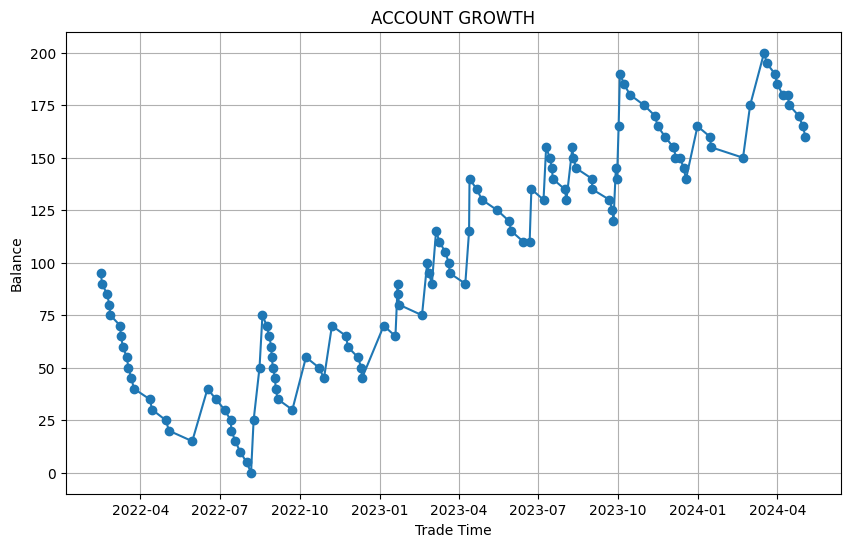

In [12]:
import matplotlib.pyplot as plt


def plot_balance_graph(backtest_results_df):
    # Ensure the DataFrame has the necessary columns
    assert (
        "Balance" in backtest_results_df.columns
    ), "The DataFrame must have a 'Balance' column."
    assert (
        "Occurrence" in backtest_results_df.columns
    ), "The DataFrame must have an 'Occurrence' column."

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(
        backtest_results_df["Occurrence"], backtest_results_df["Balance"], marker="o"
    )
    plt.title("ACCOUNT GROWTH")
    plt.xlabel("Trade Time")
    plt.ylabel("Balance")
    plt.grid(True)
    plt.show()


# Example usage:
# Assuming backtest_results_df is defined and contains the necessary columns
plot_balance_graph(backtest_results_df)